In [4]:
import os
import pandas as pd
import geopandas as gpd
import python.mod_01_0_wb_automator as wb_automator
import python.mod_01_1_pivot_rooftop_data as pivot_rooftop_analysis
import python.mod_02_pv_power_month as pv_rooftop_analysis
import python.mod_03_geopandas_facade_analyser as facade_analyser
import python.mod_04_1_ener_consum_profile_assigner as ener_cons_profile_assigner
import python.mod_04_2_energy_profile_aggregation as profile_aggregation
import python.mod_04_3_self_consump_estimation as self_cons_estimator
import python.mod_05_0_inspire_db_assigner as inspire_db_assigner
import python.mod_05_1_simple_kpi_calc as kpi_calc
import python.mod_05_2_economic_analysis as economic_analysis
import python.mod_06_enercom_estimator as enercom_estimator
import python.mod_07_self_cons_scenarios_calc as self_cons_scenarios_calc 
import python.mod_07_geo_visualization as geo_visualization

In [5]:
# Class to extract file names form the excel file
class DefaultPathsAndFileNames:
    """
    A class to hold a set of default paths for a standardized and replicable approach.
    """

    def __init__(self, excel_path='files_directories_naming.xlsx', sheet_name="Sheet1"):
        """
        Initialize the DefaultPaths class.

        Args:
            excel_path (str, optional): Path to the Excel file containing variable names.
            sheet_name (str, optional): Name of the sheet to read from the Excel file.
        
        self.BASE_DIR = "your_custom_name"  # Replace with your base directory
        self.data_dir = f"{self.BASE_DIR}/data"
        self.lidar_dir = f"{self.BASE_DIR}/lidar"
        self.vector_dir = f"{self.BASE_DIR}/vector"
        self.raster_dir = f"{self.BASE_DIR}/raster"

        # Define file names
        self.LIDAR_FILE = "lidar.las"
        self.BUILDING_FOOTPRINT_FILE = "building_footprint.shp"
        self.STATISTICAL_CENSUS_FILE = "statistical_census.shp"
        self.WHITEBOX_RT_ANALYSIS_FILE = "wb_rt_analysis.shp"
        """
        # Extract file names from Excel and set them as attributes
        if excel_path and sheet_name:
            df=self._set_file_names_from_excel(excel_path, sheet_name)
            print(df)
            self.PATH = os.getcwd() if pd.isna(df.loc['PATH', 'Name']) else f"{df.loc['PATH', 'Name']}"
            self.LIDAR_FILE = f"{df.loc['LIDAR_FILE', 'Name']}"
            self.BUILDING_FOOTPRINT_FILE = f"{df.loc['BUILDING_FOOTPRINT_FILE','Name']}"
            self.STATISTICAL_CENSUS_FILE = f"{df.loc['STATISTICAL_CENSUS_FILE','Name']}"
            self.HEATMAPS_HDEM_RASTER = f"{df.loc['HEATMAPS_HDEM_RASTER','Name']}" if 'HEATMAPS_HDEM_RASTER' in df.index else None
            self.WHITEBOX_RT_ANALYSIS_FILE = f"{df.loc['WHITEBOX_RT_ANALYSIS_FILE','Name']}"
            self.LPG_FILES_DIR = f"{df.loc['LPG_FILES_DIR','Name']}" if 'LPG_FILES_DIR' in df.index else "LoadProGen"
            self.ROOFTOP_FILE = f"{df.loc['ROOFTOP_FILE','Name']}" if 'ROOFTOP_FILE' in df.index else None
            self.SEGMENT_FILE = f"{df.loc['SEGMENT_FILE','Name']}" if 'SEGMENT_FILE' in df.index else None

            #Print the file names for demonstration
            #print("File names from Excel:\n")
            #print(f"PATH: {self.PATH}")
            #print(f"LIDAR_FILE: {self.LIDAR_FILE}")
            #print(f"BUILDING_FOOTPRINT_FILE: {self.BUILDING_FOOTPRINT_FILE}")
            #print(f"STATISTICAL_CENSUS_FILE: {self.STATISTICAL_CENSUS_FILE}")
            #print(f"WHITEBOX_RT_ANALYSIS_FILE: {self.WHITEBOX_RT_ANALYSIS_FILE}")

    def get(self, key):
        """
        Retrieve the path associated with a given key.

        Args:
            key (str): The key for the desired path.

        Returns:
            str: The corresponding path, or None if the key does not exist.
        """
        return getattr(self, key, None)

    def _set_file_names_from_excel(self, excel_path, sheet_name):
        """
        Extract file names from an Excel sheet and set them as attributes.

        Args:
            excel_path (str): Path to the Excel file.
            sheet_name (str): Name of the sheet to read.
        """
        try:
            df = pd.read_excel(excel_path, sheet_name=sheet_name, index_col=0)
            #print(df.head())
            #print(df.loc['LIDAR_FILE','File'])  # Print the row corresponding to 'LIDAR_FILE' for debugging
            # Assuming the file names are in the first column
            #file_names = df.iloc[:, 0].dropna().tolist()
            return df
        except Exception as e:
            print(f"Error reading Excel file: {e}")

In [6]:
#%% GLOBAL VARIABLES
PATH = os.getcwd() 
INPUT_FILE="00_input_data.xlsx"
default_paths = DefaultPathsAndFileNames(excel_path=INPUT_FILE, sheet_name="file_names")

WINDOW_TO_WALL_RATIO = 0.24  # Ratio of window area to wall area

                                                                    Name
Variable_name                                                           
PATH                                                                 NaN
BASE_DIR                                             spacer-hb-framework
PV_WORK_DIR                                                         data
LIDAR_FILE                                   otxarkoaga_lidar_cliped.las
BUILDING_FOOTPRINT_FILE      buildings_inspire_clip_oxarkoaga+census.shp
STATISTICAL_CENSUS_FILE                                   Otxarkoaga.shp
BUILDING_HEIGHT_RASTER           NDSM-EDIFICIOS-H30-0061-COB2_cliped.tif
HEATMAPS_HDEM_RASTER                      heat_res_curr_density_clip.tif
WHITEBOX_RT_ANALYSIS_FILE  wb_rt_analysis_bilbao_otxarkoaga_segments.shp
LPG_FILES_DIR                                                     Bilbao
ROOFTOP_FILE                01_footprint_r_area_wb_rooftop_analysis.xlsx
SEGMENT_FILE                 01_segments_s_area_wb_

### Naming for attributes of the columns in the dataframes
`build_id`, `census_id`, `year_of_constr`, `building` (`building_type`)
`r_area`, `height`

In [ ]:
standard_names = {
    "build_id": "unique building identifier",
    "census_id": "unique census identifier",
    "year_constr": "year of construction of building",
    "building": "type of building",
    "height": "height of building, m", # if available
    "r_area": "rooftop area, m2"
}
# ADJUST YOUR NAMING
YOUR_BUILDING_ID_COLUMN = "your_build_id_column_name"  # Unique building identifier
YOUR_CENSUS_ID_COLUMN = "your_census_id_column_name"  # Unique census identifier
YOUR_YEAR_CONSTR_COLUMN = "your_year_constr_column_name"  # Year of construction of building
YOUR_BUILDING_COLUMN = "your_building_column_name"  # Type of building
YOUR_HEIGHT_COLUMN = "your_height_column_name"  # Height of building, m
# RENAME your data column sot standardize
data = pd.read_csv("your_data.csv")  # Load your data)
data.rename(columns={
    YOUR_BUILDING_ID_COLUMN: "build_id",
    YOUR_CENSUS_ID_COLUMN: "census_id",
    YOUR_YEAR_CONSTR_COLUMN: "year_constr",
    YOUR_BUILDING_COLUMN: "building",
    YOUR_HEIGHT_COLUMN: "height" # remove if not available
})

### Ensure All files have the same Coordinate Reference Systems [Very Important!]

## MODULE 1 01_pivot_rooftop_data


#### 00 wb_automatiser
Provides an automated workflow for rooftop analysis using LiDAR and vector data. It leverages the Whitebox Workflows library and GeoPandas to:

1. Run WhiteBox rooftop Analysis Tool for rooftop segmentation on LiDAR point clouds to identify `area`, `slope` and `azimuth` for each recognised segment of rooftop.
2. Join building footprints with census data.
3. Add XY coordinates to rooftop segments.
4. Join rooftop segments with building and census IDs.
5. Export results as GeoJSON, Shapefile, and CSV (for further optinal selection).

In [7]:
wb_automator = wb_automator.RooftopAnalysisAutomatiserPython(
    path=PATH,
    root_dir="pyqgis_wb_automator",
    case_study_name="bilbao_otxarkoaga",
    suffix="_v2",
    crs="epsg:25830",
    census_id="census_id",
    building_ids=["build_id"],
    building_footprint_path=os.path.join(PATH, "vector", "buildings_footprint", "etrs_25830", default_paths.get("BUILDING_FOOTPRINT_FILE")),
    statistical_census_path=os.path.join(PATH, "vector", "stat_census", default_paths.get("STATISTICAL_CENSUS_FILE")),
    lidar_path=os.path.join(PATH, "lidar", default_paths.get("LIDAR_FILE")),
    )
wb_automator.run()

Starting rooftop analysis...
Rooftop analysis completed and saved to c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\pyqgis_wb_automator\bilbao_otxarkoaga_v2\wb_rt_analysis_bilbao_otxarkoaga_v2_segments.shp
Joining buildings with census...


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_01_0_wb_automator.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  joined.to_file(self.output_building_census_join)
c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\pyqgis_wb_automator\bilbao_otxarkoaga_v2\wb_rt_analysis_bilbao_otxarkoaga_v2_segments.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Adding XY coordinates to rooftops...
Joining rooftops with building and census IDs...
All tasks completed.


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_01_0_wb_automator.py:106: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  joined.to_file(self.output_final_shp)
c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'epsg:25830_x' to 'epsg_25830'
  ogr_write(
c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'epsg:25830_y' to 'epsg_258_1'
  ogr_write(
c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


#### 01_pivot_rooftop_data

Processes and summarizes rooftop analysis results. It reads Whitebox-generated rooftop segments and building footprints, classifies roof slopes and aspects, handles missing or inconsistent IDs, and pivots the data to aggregate rooftop areas by building and orientation. The results are exported as GeoJSON, Excel, and can be used for further analysis of rooftop characteristics at the building level.

In [8]:
azimuth_categories = {
    'roof_N': (337.5, 22.5),
    'roof_NE': (22.5, 60),
    'roof_E': (60, 111),
    'roof_SE': (111, 162),
    'roof_S': (162, 198),
    'roof_SW': (198, 249),
    'roof_W': (249, 300),
    'roof_NW': (300, 337.5),
    'flat_roof': (0, 0)
}
rt = pivot_rooftop_analysis.PivotRooftopAnalysis(file_dir=PATH,path_to_wb_rooftop_analysis='pyqgis_wb_automator\\bilbao_otxarkoaga_v2\\00_wb_rt_analysis_bilbao_otxarkoaga_v2_segments_xy_coord.geojson', path_to_buildings_footprint='vector\\buildings_footprint\\etrs_25830\\buildings_inspire_clip_oxarkoaga+census.shp')

df_segments_wb_rooftop_analysis, gdf_building_footprint = rt.process_DataFrames()
df_segments_wb_rooftop_analysis, building_footprint = rt.pivot_whitebox_rooftop_analysis(df_segment=df_segments_wb_rooftop_analysis, df_buildings_footprint=gdf_building_footprint, col_name="s_area", key_ids=["build_id", "census_id"])

c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option COL_INDEX
  return ogr_read(


File(s) saved to: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework/data


## MODULE 2 02_pv_calc_rooftop
Calculates monthly photovoltaic (PV) energy production for building rooftops. It reads panel and site parameters from Excel, processes rooftop and segment data, computes solar irradiance, and estimates PV output for each month. Results are aggregated by building, including installed capacity and monthly/annual energy yield, and exported to Excel for further analysis.

In [9]:
pv_calculator = pv_rooftop_analysis.PVMonthCalculator(INPUT_FILE)
pv_calculator.calculate()

Type of energy installation: PV
District: OTXARKOAGA
Roof area and slope data loaded:
-- data structure in file `00_input_data.xlsx`
-- data folder `data`
-- rooftop data file `01_footprint_r_area_wb_rooftop_analysis.xlsx`
-- segment data file `01_segments_s_area_wb_rooftop_analysis.xlsx`
-- two tables loaded: `rooftop` (329 rows) and `segment` (944 rows)
month -  1
month -  2
month -  3
month -  4
month -  5
month -  6
month -  7
month -  8
month -  9
month -  10
month -  11
month -  12

Result saved to file `data\02_footprint_r_area_wb_rooftop_analysis_pv_month_pv.xlsx`


## MODULE 3
Analyzes building facades using GeoPandas. It loads building footprint polygons, calculates facade lengths by orientation (N, S, E, W, etc.), identifies neighboring buildings, and computes adjusted facade lengths accounting for shared walls. It also estimates facade areas, building surface area, volume, and surface-to-volume ratio, exporting the results for further analysis.

- Total surface area / total envelope area / gross building envelope → All bounding surfaces.
- Facade area / exposed envelope / external exposed surface → Only parts exposed to ambient air.

In [ ]:
analyser = facade_analyser.FacadeAnalyser()

# Load polygons
analyser.load_polygons()
# (Optional) Merge height data if available
height_data_path = os.path.join(os.getcwd(), "vector","buildings_footprint", "height.geojson")
if os.path.exists(height_data_path):
    gdf_height = gpd.read_file(height_data_path).round(4)
    analyser.polygons_gdf = analyser.polygons_gdf.merge(
        gdf_height[['build_id', 'h_mean', 'h_stdev', 'h_min', 'h_max']],
        on='build_id', how='left'
    )
# Calculate area and perimeter
analyser.polygons_gdf['f_area'] = round(analyser.polygons_gdf['geometry'].area, 4)
analyser.polygons_gdf['f_perimeter'] = round(analyser.polygons_gdf['geometry'].length, 4)

# Calculate mean height if not provided
print("Estimated num of floors `n_floorsEstim` calculated as h_mean / 3.0")
analyser.polygons_gdf['n_floorsEstim'] = (analyser.polygons_gdf['h_mean'] / 3.0).round(0)
print("Estimated height `h_estim` calculated as n_floorsEstim * 3.0 + 1")
analyser.polygons_gdf['h_estim'] = analyser.polygons_gdf['n_floorsEstim'] * 3.0 + 1

# Calculate facade lengths per orientation
facades_per_orientation_len_df = analyser.length_per_orientation()

# Find neighbors and their lengths per orientation
analyser.list_neighboring_polygons()
adjusted_facades_len_df = analyser.length_of_neighbors_per_orientation()

# Calculate surface area, volume, and s/v ratio
analyser.polygons_gdf['surface_area'] = analyser.polygons_gdf.apply(analyser.calculate_surface_area, axis=1)
analyser.polygons_gdf['volume'] = analyser.polygons_gdf.apply(analyser.calculate_volume, axis=1)
analyser.polygons_gdf['s_v_ratio'] = analyser.polygons_gdf.apply(analyser.calculate_s_v_ratio, axis=1).round(4)

# Subtract facade lengths
result_df = analyser.subtract_facade_len_from_adjusted_sides(facades_per_orientation_len_df, adjusted_facades_len_df)

# Calculate facade area per orientation
fadace_length_cols = {'len_N': 'N', 'len_NE': 'NE', 'len_E': 'E',
                        'len_SE': 'SE', 'len_S': 'S', 'len_SW': 'SW', 'len_W': 'W', 'len_NW': 'NW'}
for key, value in fadace_length_cols.items():
    result_df[f"fa_area_{value}"] = [0 if x < 0.1 else x for x in result_df[key]] * result_df['h_mean']
    print(f"The length of facade less than 1m assigned to 0, for orientation {key} number of records is: {result_df[key].loc[result_df[key] < 1].count()}")

print(f"Facade area per orientation calculated successfully.")

result_df=analyser.recalculate_surface_area(result_df)

print ("Calculation of window area per building with fixed window to wall ratio")
result_df=analyser.assign_window_areas(result_df, windows_to_wall_ratio=WINDOW_TO_WALL_RATIO)
result_df['f_v_ratio'] = result_df.apply(analyser.calculate_f_v_ratio, axis=1).round(4) # Facade to volume ratio

# Save results
result_df.to_file("data/03_footprint_subtracted_facades_and_s_v_volume_area.geojson", driver="GeoJSON", index=False)
result_df.drop(columns=['geometry']).to_csv("data/03_footprint_subtracted_facades_and_s_v_volume_area.csv", index=False)

c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option INDEX_COL
  return ogr_read(


       build_id   census_id  wb_build_id  Codigo_Mun  Codigo_Pol  Codigo_Par  \
0  201303200512  4802003003            0          20        1303        2005   
1  201303200611  4802003003            1          20        1303        2006   
2  201303100611  4802003003            2          20        1303        1006   
3  201303200612  4802003003            3          20        1303        2006   
4  201303100612  4802003003            4          20        1303        1006   

   Codigo_Sub  Codigo_Edi  Codigo_Cal Numero_Por  ...   roof_S roof_SE  \
0           1           2        9574        021  ...  65.7649     0.0   
1           1           1        9574        017  ...  70.0141     0.0   
2           1           1        9227        004  ...   0.0000     0.0   
3           1           2        9574        015  ...  62.4606     0.0   
4           1           2        9227        002  ...   0.0000     0.0   

   roof_SW  roof_W  flat_roof  plain_roof    r_area  exception wb_max_elev

## MODULE 4

### 4.1 04_ener_consum_profile_assigner

This class assigns detailed residential energy consumption profiles to census areas based on demographic and dwelling data. It reads census and dwelling statistics, applies demographic coefficients to estimate the distribution of household types (by size and composition), and generates synthetic energy consumption profiles for each group. The results are exported as a CSV for further energy modeling and analysis.

In [ ]:
dwelling_percentages_dict = {
    "single_dwellings": {
    "percentage_of_people_20_24_live_alone": 0.5,
    "percentage_of_people_25_65_live_alone": 0.25,
    "percentage_of_people_65_live_alone": 0.33
    },
    "two_people_dwellings": {
    "couples_25_65_without_kids": 0.11,
    "couples_65_without_kids": 0.33,
    "monoparental_25_65": 0.1
    },
    "three_five_people_dwellings": {
    "couples_25_65_with_kids": 0.47,
    "coeff_1_children": 0.46,
    "coeff_2_children": 0.44,
    "coeff_3_more_children": 0.1
    }
}
assigner = ener_cons_profile_assigner.EnergyConsumptionProfileAssigner(
    dwelling_percentages_dict=dwelling_percentages_dict)
assigner.process()

### 4.2 04_energy_profile_aggregation

This script aggregates and generates hourly energy consumption profiles for residential buildings based on dwelling types and occupancy. It combines synthetic load profiles with census-based dwelling distributions, allowing for different shares of PV adoption. The results are exported as CSV files for further energy system analysis, supporting scenario modeling with and without PV integration.

In [ ]:
LPG_FILES_FOLDER = os.path.join(PATH,"LoadProGen", default_paths.get("LPG_FILES_DIR"))
# Instantiate and use the class
pv_pct_list = [0.25, 0.5, 0.75, 1]
profile_names= {
    #"1P_Occup": "ND1 Single Occupied Dwellings",
    "1P_Work": "CHR07 Single with work",
    "Stu_Work": "CHR13 Student with Work",
    "1P_Ret": "CHR30 Single, Retired Man/Woman",
    #"2P_Occup": "ND2 Two People Occupied Dwellings",
    "Couple_Work": "CHR01 Couple both at Work",
    "Couple_65+": "CHR16 Couple over 65 years",
    "1P_1Ch_Work": "CHR22 Single woman, 1 child, with work",
    #"3-5P_Occup": "ND3-5 Three to Five People Occupied Dwellings",
    "Fam_1Ch_Work": "CHR03 Family, 1 child, both at work",
    "Stu_Share": "CHR52 Student Flatsharing",
    "Fam_2Ch_Work": "CHR27 Family both at work, 2 children",
    "Fam_3Ch_Work": "CHR41 Family with 3 children, both at work",
    "Fam_1Ch_1Wrk1Hm": "CHR45 Family with 1 child, 1 at work, 1 at home",
    "Fam_3Ch_1Wrk1Hm": "CHR20 Family one at work, one work home, 3 children",
    "Fam_3Ch_HmWrk": "CHR59 Family, 3 children, parents without work/work at home",
    #"6-9P_Occup": "ND6-9 Six to Nine People Occupied Dwellings",
    "6-9P_Occup_id_1": "id_1",
    "6-9P_Occup_id_3": "id_1",
    #"10+P_Occup": "ND10 (Ten or more People Occupied Dwellings)",
    "10+P_Occup_id_1": "id_1",
    "10+P_Occup_id_2": "id_1"
}
for pv_pct in pv_pct_list:
    aggregator = profile_aggregation.EnergyProfileAggregator(LPG_FILES_FOLDER, profile_names, pv_pct=pv_pct)
    #aggregator.plot_profiles()
    result_pv_df, result_no_pv_df = aggregator.save_results()

### 4.3 04_self_consump_estimation
This subsection´s scrip estimates and analyzes self-consumption of PV energy in census sections (bu defaul focusing on residential buildings). It loads aggregated hourly PV generation and consumption profiles, aligns and aggregates them by month and season, and calculates self-consumption rates and coverage with and without PV. Results are exported as CSV files for further analysis of energy community performance and PV integration impacts at the census area level.

In [ ]:
for pv_pct in pv_pct_list:
    estimator = self_cons_estimator.SelfConsumptionEstimator(
        work_dir="data",
        district="otxarkoaga",
        pv_pct=pv_pct
    )
    #estimator.time_alignment()
    estimator.run_self_consumption()
    monthly_agg, monthly_agg_no_pv = estimator.save_aggregated_profiles()
    pv_census_aggreg_df = estimator.save_pv_profiles()
    estimator.save_net_balance(monthly_agg, pv_census_aggreg_df)

### MODULE 5

#### 05_inspire_db_assigner
This piece of code assigns building-level energy demand, consumption (and as side priority: CO₂ emission) values using the INSPIRE database methodology. It processes building geometry data, calculates surface-to-volume ratios, estimates facade and window areas, and applies empirical equations based on construction period to compute heating, cooling, and emissions indicators. Results are exported as GeoJSON for further spatial analysis.

In [11]:
heating_db_assigner = inspire_db_assigner.InspireDBAssigner()
heating_db_assigner.load_data()
heating_db_assigner.process()
heating_db_assigner.save()

# Load layers
buildings = gpd.read_file(os.path.join(PATH, "data","05_buildings_with_energy_and_co2_values.geojson"))
h_dem = gpd.read_file(os.path.join(PATH,"vector","hm_raster_25830.shp"))

# Perform spatial join (predicate = intersects or within)
joined = gpd.sjoin(buildings, h_dem[['HDemProj', 'geometry']], how='left', predicate='intersects')

# Drop duplicates by index to mimic METHOD=2 (take first match only)
joined = joined[~joined.index.duplicated(keep='first')]

# Export to GeoJSON
joined.to_file(os.path.join(PATH, "data","05_buildings_with_energy_and_co2_values+HDemProj.geojson"), driver='GeoJSON')

cols: Index(['build_id', 'census_id', 'building', 'year_const', 'r_area', 'h_mean',
       'h_stdev', 'h_min', 'h_max', 'f_area', 'f_perimeter', 'n_floorsEstim',
       'h_estim', 'len_N', 'len_NW', 'len_E', 'len_SW', 'len_S', 'len_SE',
       'len_W', 'len_NE', 'neighboring_polygons', 'surface_area', 'volume',
       's_v_ratio', 'fa_area_N', 'fa_area_NE', 'fa_area_E', 'fa_area_SE',
       'fa_area_S', 'fa_area_SW', 'fa_area_W', 'fa_area_NW', 'Total_fa_area',
       'Tot_w2wall', 'Tot_window_area', 'Total_wall_area', 'f_v_ratio',
       'geometry', 'HDem_iNSPiRE', 'HCons_iNSPiRE', 'CDem_iNSPiRE',
       'CCons_iNSPiRE', 'H_CO2_iNSPiRE'],
      dtype='object')
Data saved to 05_buildings_with_energy_and_co2_values.geojson


#### 05_1_simple_kpi_calc

This code calculates and analyzes economic key performance indicators (KPIs) for building retrofits and PV installations. The general description of the functionality can be split up as:
- it merges PV generation, building geometry, and cost data; 
- estimates investment and maintenance costs for facades, windows, and roofs; 
- adjusts heating demand based on retrofit scenarios; and 
- computes PV self-consumption, grid export, and related savings. 

Results are exported as GeoJSON and Excel files for further economic and energy scenario analysis.

Preparing facades data by merging with PV generation data...
Facades data prepared with PV generation information.
Filtering PV data, by column: building with value: V
Filter PV generation by type of building...


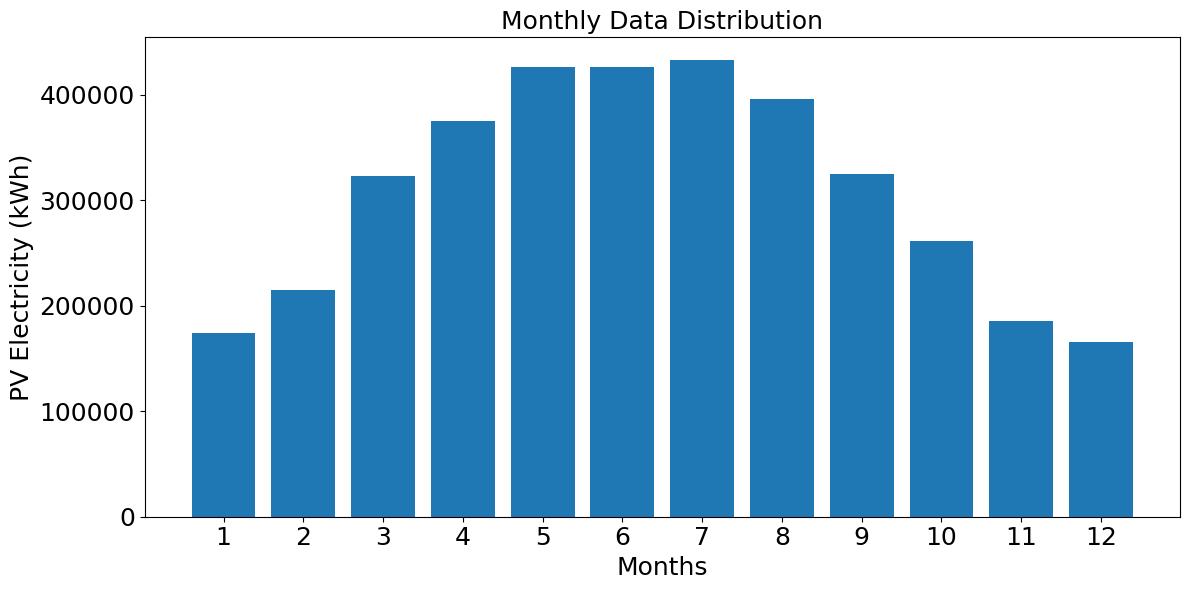

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_05_1_simple_kpi_calc.py:70: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pv_gen_census = self.df_pv_gen.groupby('census_id').sum()


Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')
[[32185. 38689. 56545. 64010. 71405. 70828. 72216. 67091. 56342. 46490.
  33885. 30851.]
 [23532. 29778. 46049. 54996. 63706. 64247. 65017. 58586. 46978. 36618.
  25170. 21949.]
 [10864. 13662. 20997. 24933. 28761. 28947. 29320. 26496. 21347. 16739.
  11588. 10164.]
 [12926. 16306. 25142. 29940. 34601. 34856. 35288. 31841. 25590. 20003.
  13799. 12073.]
 [29336. 36487. 55421. 65129. 74595. 74862. 75933. 69038. 56124. 44533.
  31210. 27623.]
 [ 9295. 11941. 18751. 22705. 26545. 26877. 27149. 24286. 19249. 14778.
   9989.  8596.]
 [22500. 28699. 44757. 53864. 62712. 63390. 64083. 57501. 45805. 35407.
  24121. 20892.]
 [34023. 39395. 55029. 59405. 63887. 62300. 64018. 61318. 53739. 46506.
  35428. 33223.]]


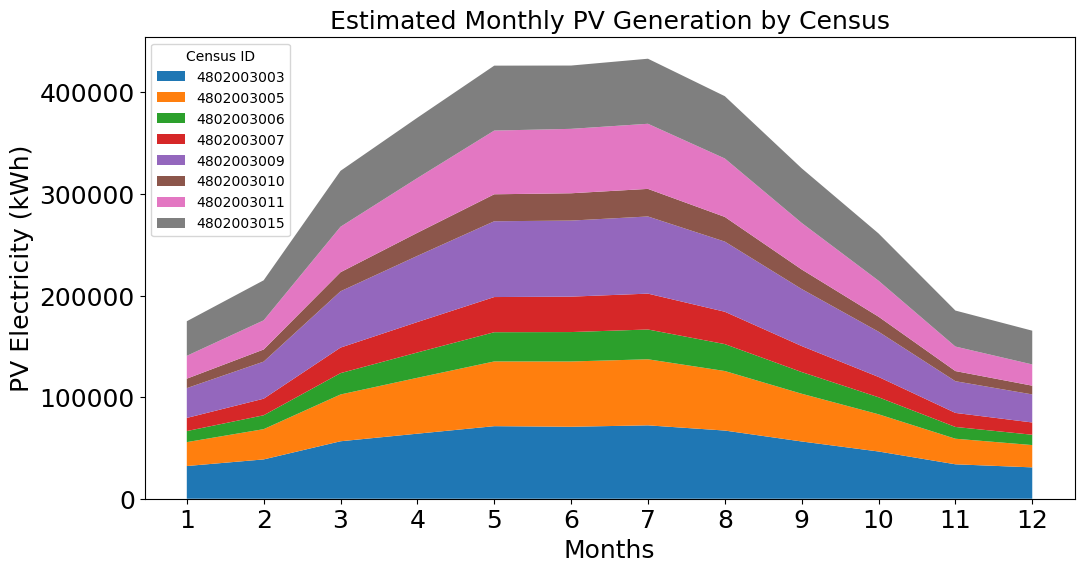

Heating demand reduction coefficient for Pais_Vasco, S1, ['facade', 'roof']: 0.29
By default, the adjusted value is the value of `HDemProj` when the condition is not met
Heating demand reduction coefficient for Pais_Vasco, S1, ['facade', 'windows', 'roof']: 0.62
By default, the adjusted value is the value of `HDemProj` when the condition is not met
Heating demand reduction coefficient for Pais_Vasco, S2, ['facade', 'roof']: 0.38
By default, the adjusted value is the value of `HDemProj` when the condition is not met
Heating demand reduction coefficient for Pais_Vasco, S2, ['facade', 'windows', 'roof']: 0.74
By default, the adjusted value is the value of `HDemProj` when the condition is not met
         build_id   census_id  PV_self_cons_kWh  PV_to_grid_kWh  \
0    201303200512  4802003003          2463.625        7390.875   
1    201303200611  4802003003          2591.260        7773.781   
2    201303100611  4802003003          2259.823        6779.468   
3    201303200612  4802003003 

In [12]:
pv_file_name = "02_footprint_r_area_wb_rooftop_analysis_pv_month_pv.xlsx"

analyzer = kpi_calc.EconomicKPIAnalyzer(PATH, pv_file_name, cost_file_name=INPUT_FILE)
df_pv_filt = analyzer.prepare_facades()
analyzer.plot_pv_generation()

analyzer.plot_census_stackplot()

SCENARIO = ["S1","S2"]
REGION = 'Pais_Vasco'
COMBINATION_ID = [1,2]#2
intervention_combinations = {
    1: ["facade", "roof"],
    2: ["facade", "windows", "roof"],
}
heating_energy_price_euro_per_kWh = 0.243
energy_price_growth_rate = 0
pv_degradation_rate = 0
ESTIM_AVG_DWE_SIZE =55 # Average dwelling size in m2, used for heating demand calculation

for scenario in SCENARIO:
    for combination_id in COMBINATION_ID:
        analyzer.calculate_costs(scenario)
        analyzer.calculate_heating_demand(REGION, scenario, combination_id, ESTIM_AVG_DWE_SIZE, intervention_combinations, heating_energy_price_euro_per_kWh)

analyzer.save_facades("data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs_with_HDem_corr.geojson")

analyzer.calculate_pv_costs()
analyzer.save_pv_to_excel()
analyzer.join_pv_costs_to_facades()
analyzer.save_facades_with_pv("data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV.geojson")
analyzer.calculate_pv_metrics(pv_degradation_rate, energy_price_growth_rate)
analyzer.save_economic_analysis(
    "data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic.geojson",
    "data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic_otxarkpaga_orginal_price_incr+pv_degrad.xlsx"
)

#### 05_2_economic_analysis 

This code performs economic analysis of building retrofit and PV scenarios at the district level.
- It loads building, energy, and cost data; 
- filters for residential buildings with PV; 
- calculates economic indicators such as EUAC (Equivalent Uniform Annual Cost), present value, and savings for different intervention combinations; and 
- aggregates results by census area. 

The code also generates summary plots and exports results to Excel, supporting scenario comparison for energy and economic planning.

    census_id  Envelope_EUAC       PV_EUAC  Envelope_Energy_kWh  \
0  4802003003  533310.333008 -51831.060502         2.194693e+06   
1  4802003005  814706.240940 -35731.118419         3.352701e+06   
2  4802003006  350232.394604 -16508.384810         1.441286e+06   
3  4802003007  431297.305825 -19722.567042         1.774886e+06   
4  4802003009  629439.528924 -44595.930889         2.590286e+06   
5  4802003010  290819.851878 -14598.788499         1.196790e+06   
6  4802003011  501813.496091 -35091.996229         2.065076e+06   
7  4802003015  386285.143647 -51506.244085         1.589651e+06   

   Envelope_Annual_Cost  PV_Annual_Cost     Total, kWh           EUAC  \
0         533310.333008      -75576.267  640537.938014  481479.272506   
1         814706.240940      -61320.693  536624.797046  779047.847317   
2         350232.394604      -27934.312  243818.768951  333724.009793   
3         431297.305825      -33474.173  292366.141129  411574.738783   
4         629439.528924      -7

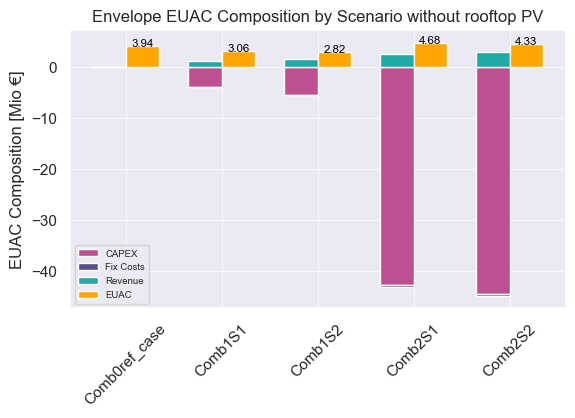

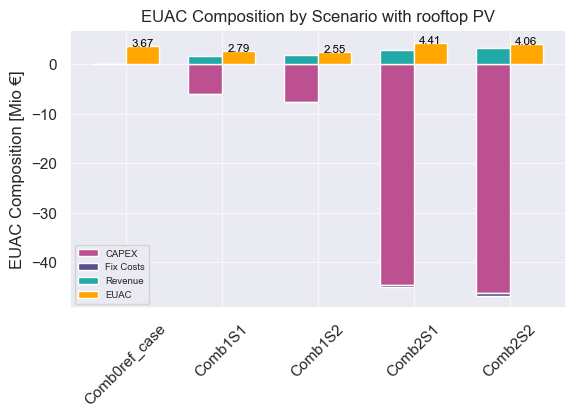

In [13]:
root = os.getcwd()  # or specify your root directory
analysis = economic_analysis.EconomicAnalysis(root)
analysis.run_analysis(CAL_REFERENCE_CASE=True)
for scenario in SCENARIO:
    for combination_id in COMBINATION_ID:
        analysis.run_analysis(SCENARIO=scenario, COMBINATION_ID=combination_id)

analysis.save_to_excel("05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic+EUAC_ORIGIN")
analysis.plot_neighbourhood("output_filename",euac_col="Envelope_EUAC")
analysis.plot_neighbourhood("output_filename",euac_col="EUAC")

## MODULE 07

#### 07_self-cons_scenarios_calc

This subsection analyzes PV self-consumption scenarios at the district and census area level. 
- It loads PV generation, building, and consumption data; 
- calculates monthly and annual self-consumption for different shares of dwellings participating in energy communities; and
-  visualizes results with plots and heatmaps. 

The outputs help assess the impact of PV sharing scenarios on self-consumption and self-sufficiency for residential districts.

43223.6236 m2 of PV area in Otxarkoaga
dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_07_self_cons_scenarios_calc.py:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pv_temp = self.df_pv_gen.groupby('build_id').sum().reset_index()
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_07_self_cons_scenarios_calc.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen_census = self.df_pv_gen.groupby('census_id').sum()


04_self_cons_pct_month_0.25.csv  :  0.25
04_self_cons_pct_month_0.5.csv  :  0.5
04_self_cons_pct_month_0.75.csv  :  0.75
04_self_cons_pct_month_1.csv  :  1


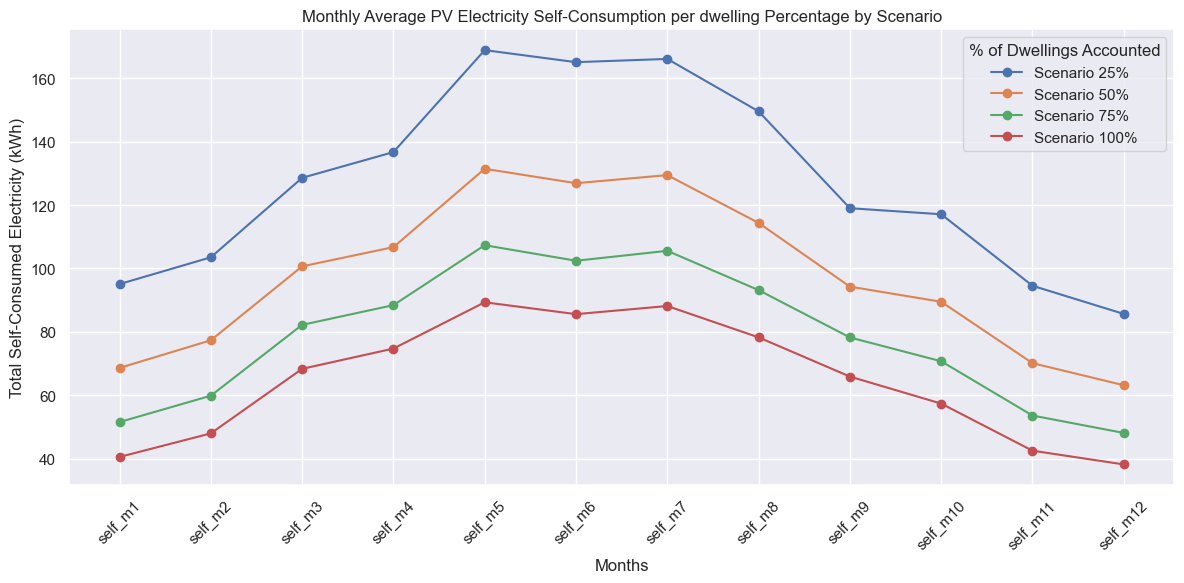

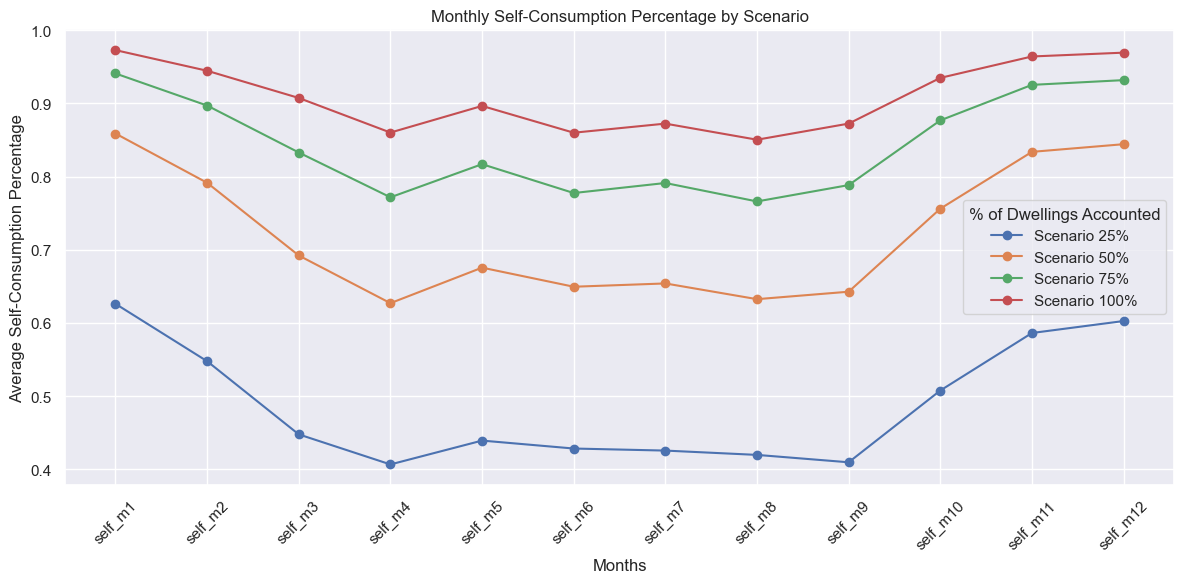

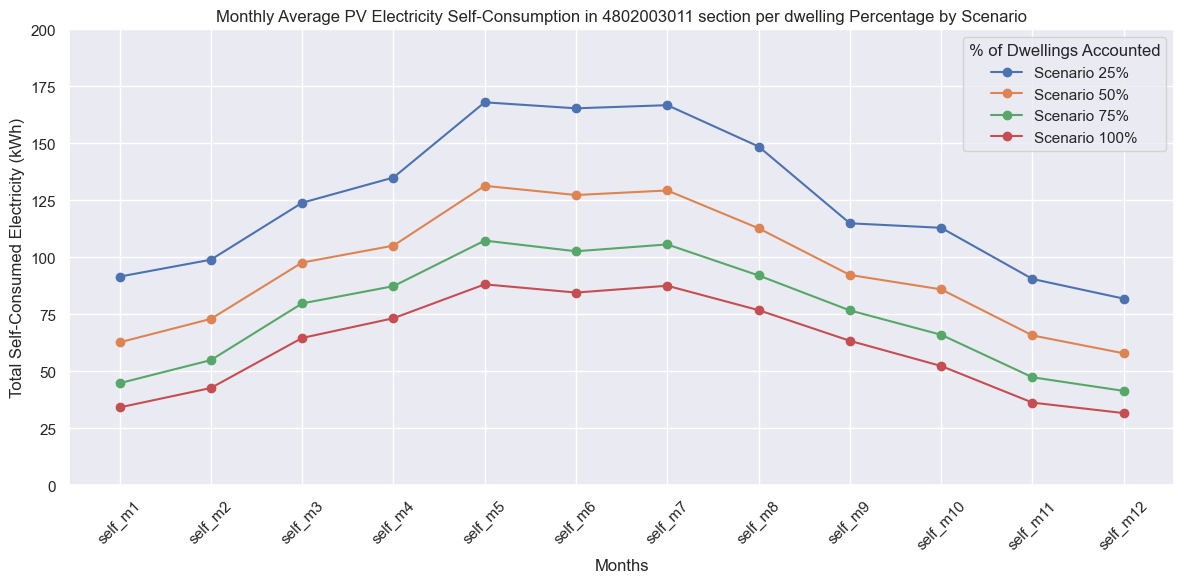

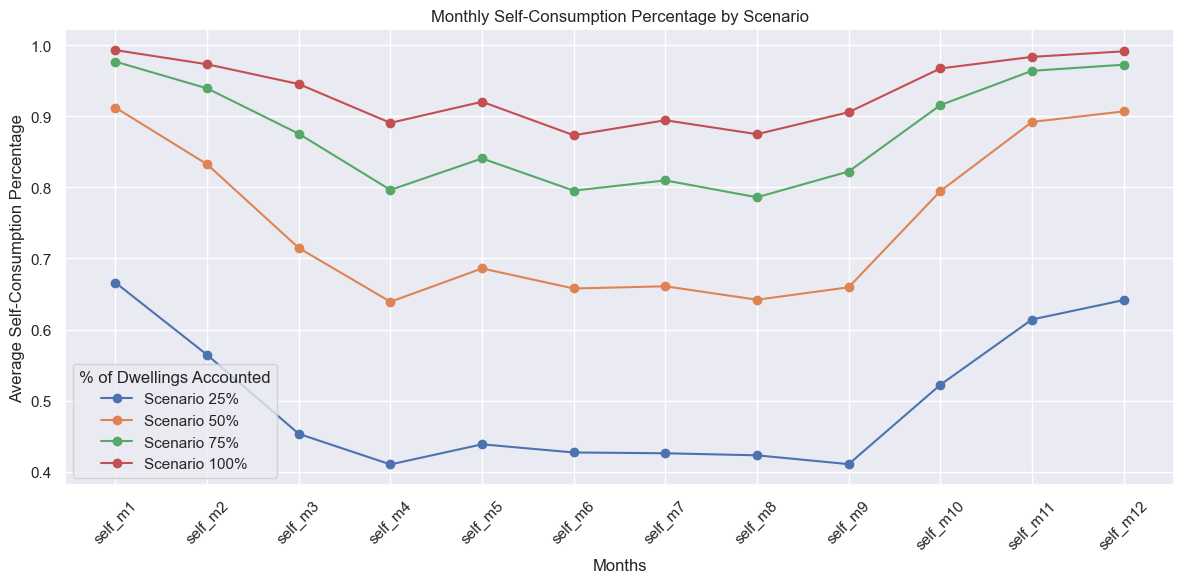

04_aggreg_cons_prof_with_pv_by_census_id_monthly_0.25.csv  :  0.25
04_aggreg_cons_prof_with_pv_by_census_id_monthly_0.5.csv  :  0.5
04_aggreg_cons_prof_with_pv_by_census_id_monthly_0.75.csv  :  0.75
04_aggreg_cons_prof_with_pv_by_census_id_monthly_1.csv  :  1


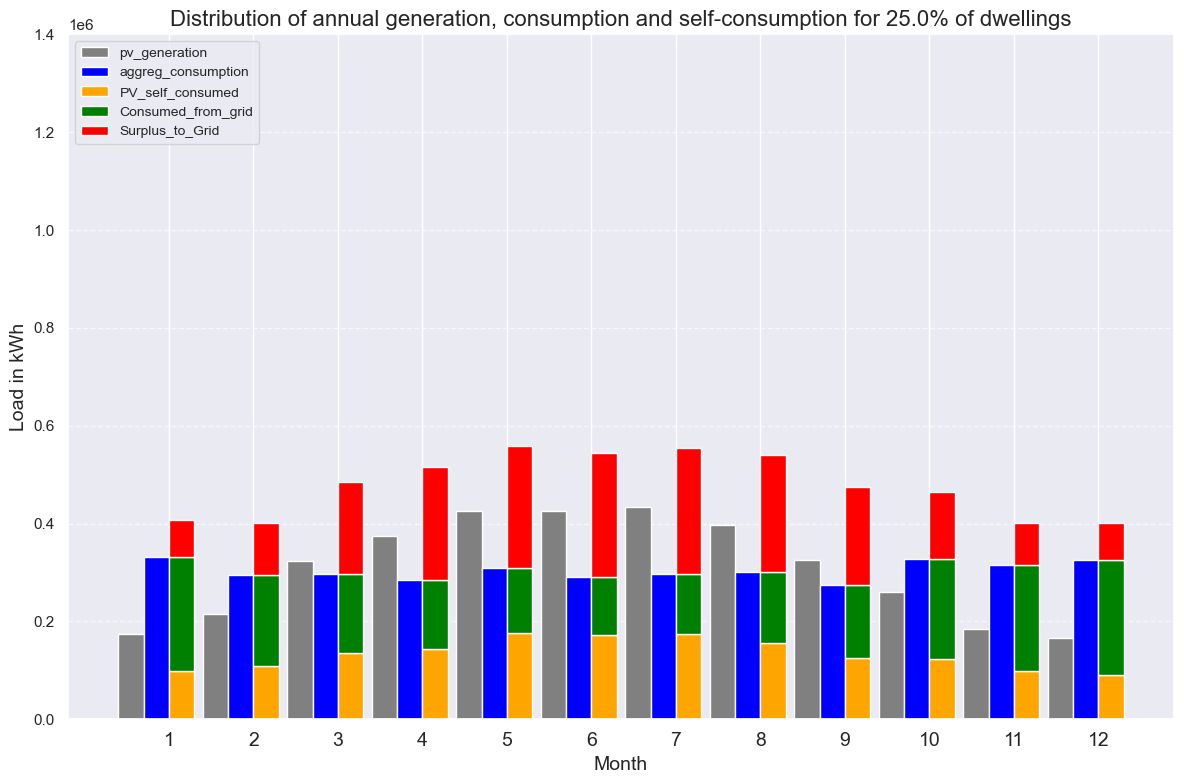

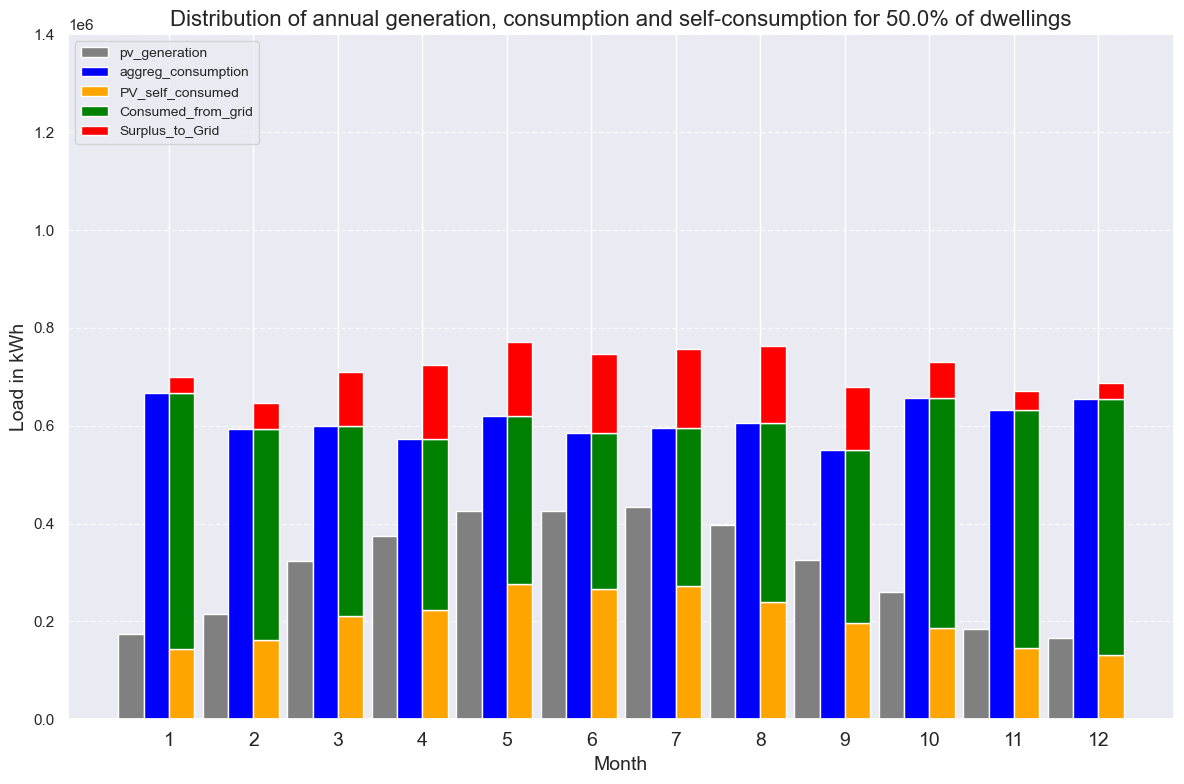

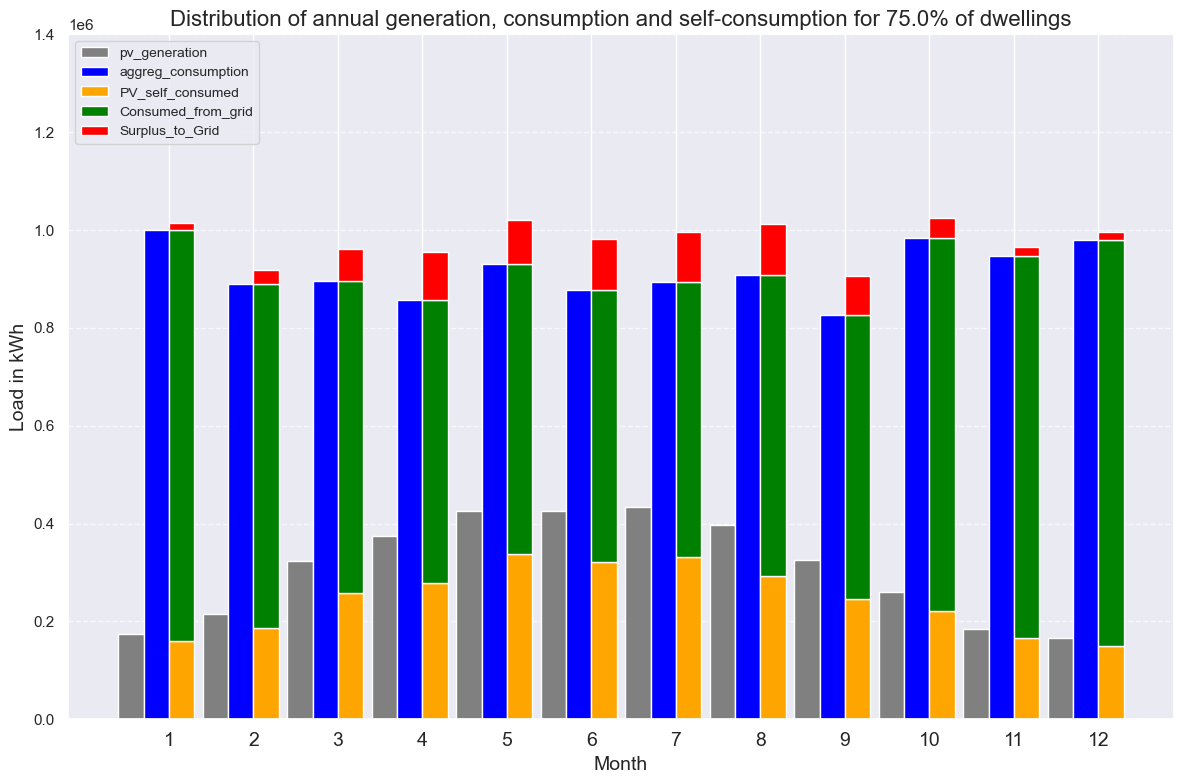

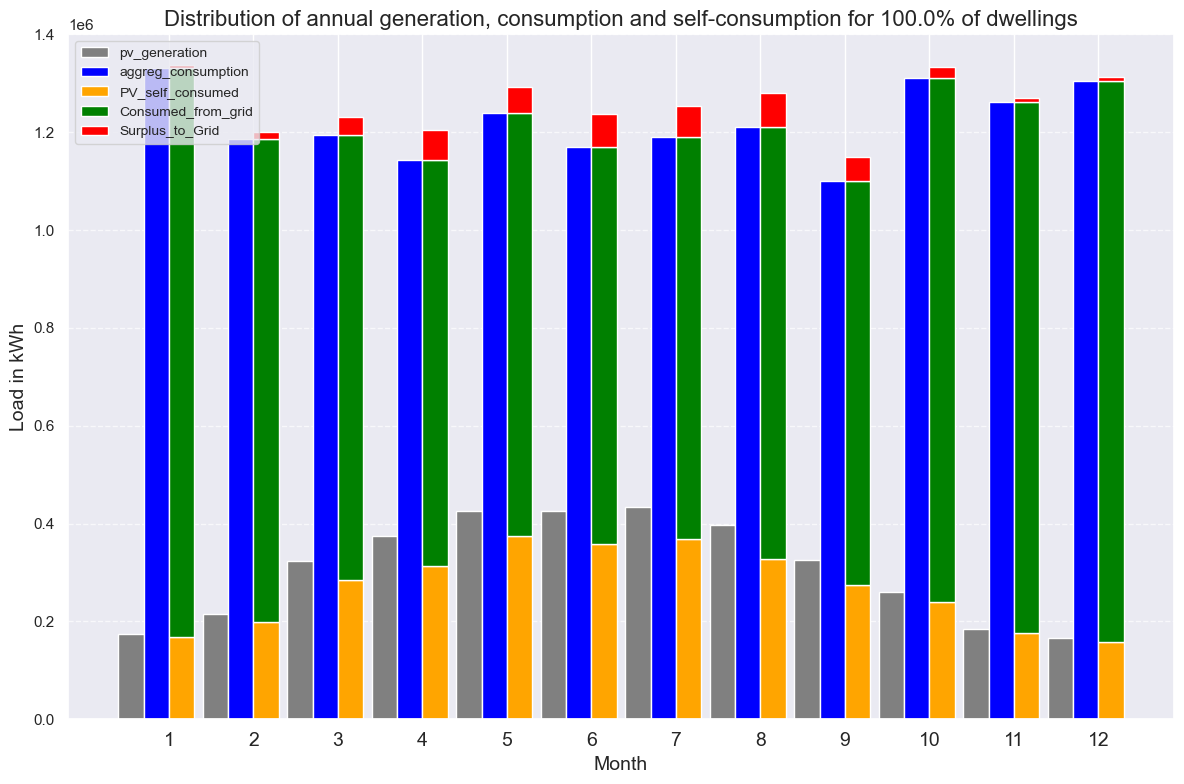

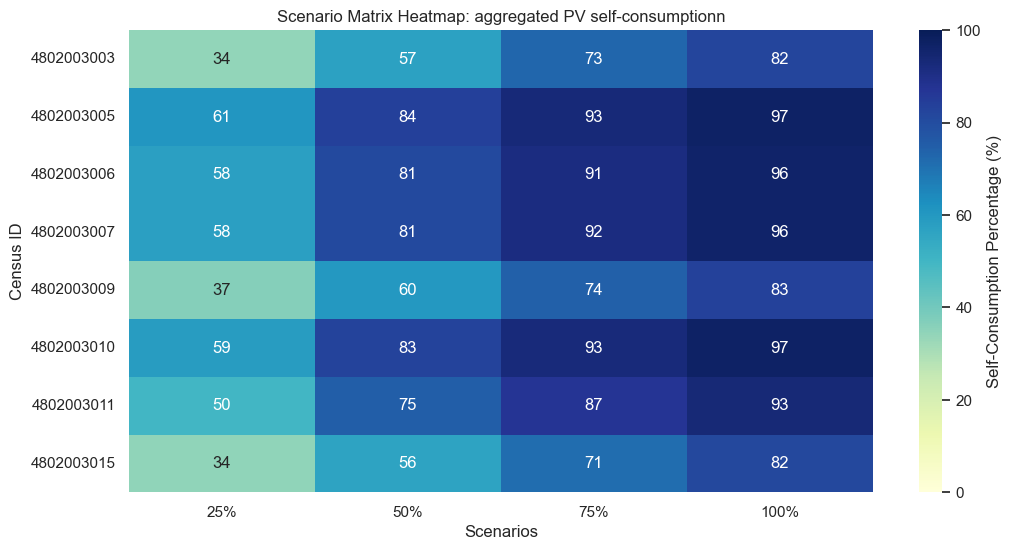

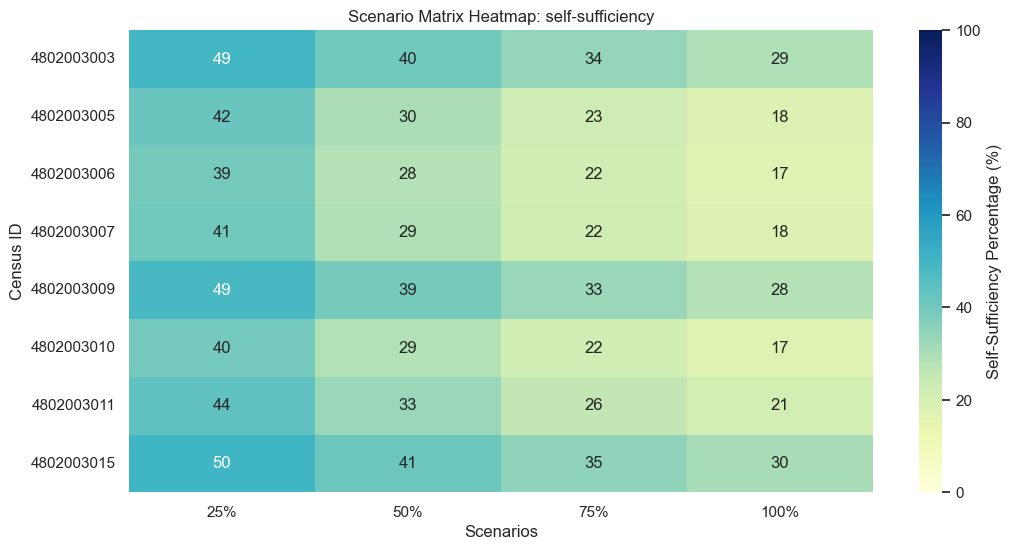

In [14]:
self_cons_analysis = self_cons_scenarios_calc.SelfConsumptionAnalysis(PATH)
self_cons_analysis.calculate_self_consumption()
self_cons_analysis.calculate_per_dwelling()
CENSUS_ID = 4802003011
df_self_cons_calc_per_dwelling_filter, df_self_cons_pct_filer = self_cons_analysis.filter_by_census_id(CENSUS_ID)
self_cons_analysis.plot_self_consumption_trends(
    df_self_cons_calc_per_dwelling_filter,
    df_self_cons_pct_filer,
    xlabel='Months',
    ylabel='Total Self-Consumed Electricity (kWh)',
    header=f'Monthly Average PV Electricity Self-Consumption in {CENSUS_ID} section per dwelling Percentage by Scenario',
    y_min=0, y_max=200
)
self_cons_analysis.load_consumption_data()
self_cons_analysis.filter_per_dwelling_percentage()
self_cons_analysis.create_heatmap()
self_cons_analysis.calculate_self_sufficiency()

#### 07_geo_visualization

The code of this class provides geospatial visualization tools for energy and economic indicators at the census section level. It merges census geometries with building or scenario data and generates heatmaps for metrics such as energy demand, CO₂ emissions, non-renewable primary energy (NRPE), and economic costs (EUAC). 

The visualizations support scenario comparison and spatial analysis of building retrofit and PV impacts across districts.

c:\Users\Oleksandr-MSI\anaconda3\envs\spacer-hb\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


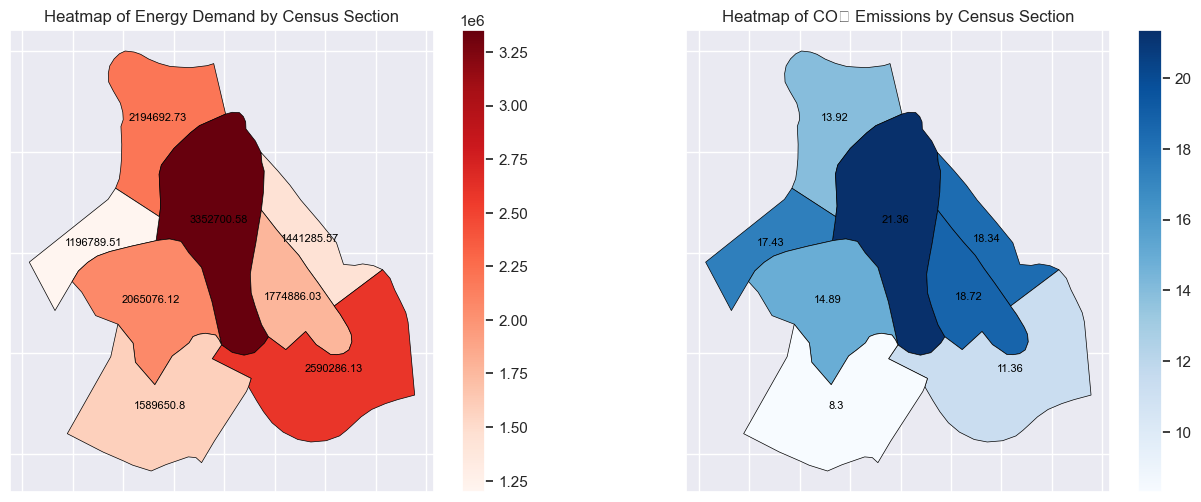

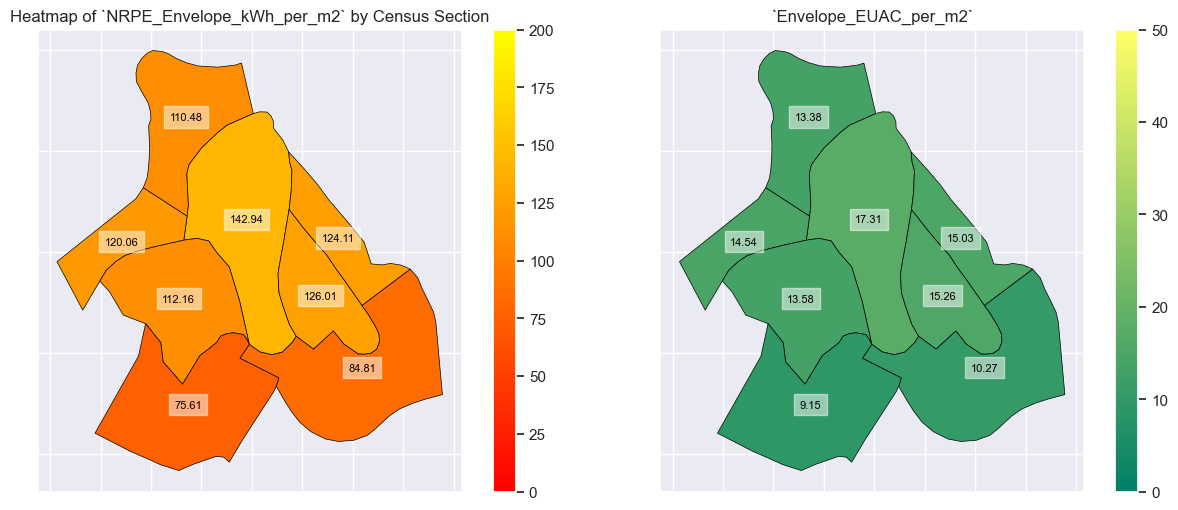

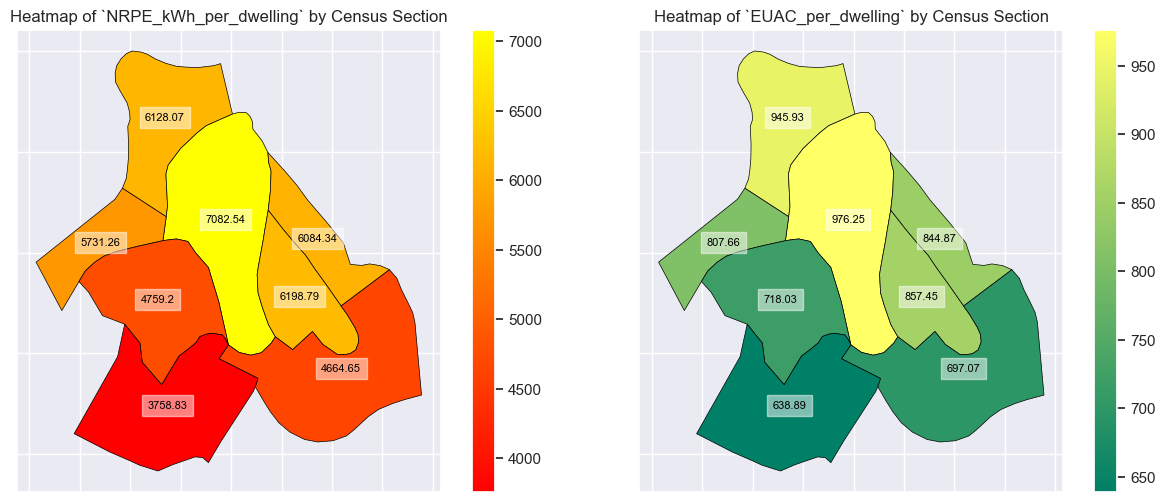

In [16]:
census_file = os.path.join(os.getcwd(), "vector", "stat_census", "Otxarkoaga.shp")
data_file = os.path.join(os.getcwd(), "data", "05_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic+EUAC_ORIGIN_ADD_SHEET.xlsx")

# Pass the desired filter value as an argument
visualizer = geo_visualization.GeoHeatmapVisualizer(census_file, data_file, filter_value='Comb0ref_case', sheet_name="Sheet0")
visualizer.plot_energy_co2_heatmaps()
visualizer.geo_heatmap(column_1='NRPE_Envelope_kWh_per_m2', column_2='Envelope_EUAC_per_m2', vmin1=0, vmax1=200, vmin2=0, vmax2=50)
visualizer.geo_heatmap_no_colorbar(column_1='NRPE_kWh_per_dwelling', column_2='EUAC_per_dwelling')

## MODULE 6
#### 06_enercom_estimator.py
This script estimates and compares annual and monthly energy costs for residential energy communities under different PV adoption rates and electricity pricing scenarios.

- it aggregates PV generation and consumption data by census area;
- calculates self-consumption, grid export, and cost savings for both PV and non-PV households; and
- performs sensitivity analysis on price and participation rates.

Results are exported to Excel and visualized with bar plots to support scenario analysis and policy evaluation.

Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

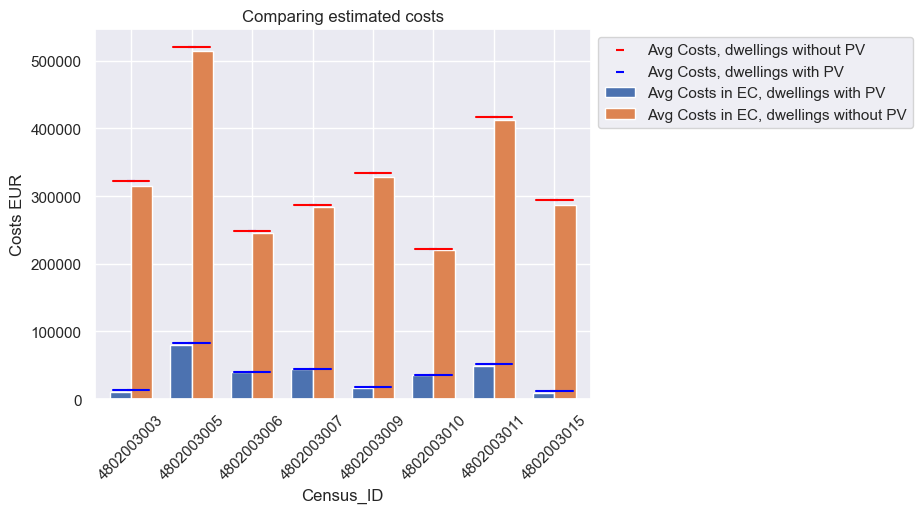

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

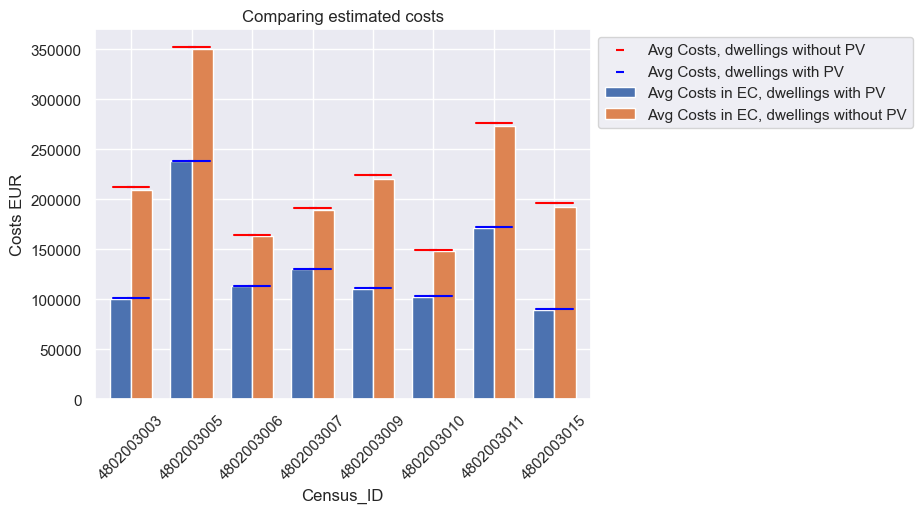

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

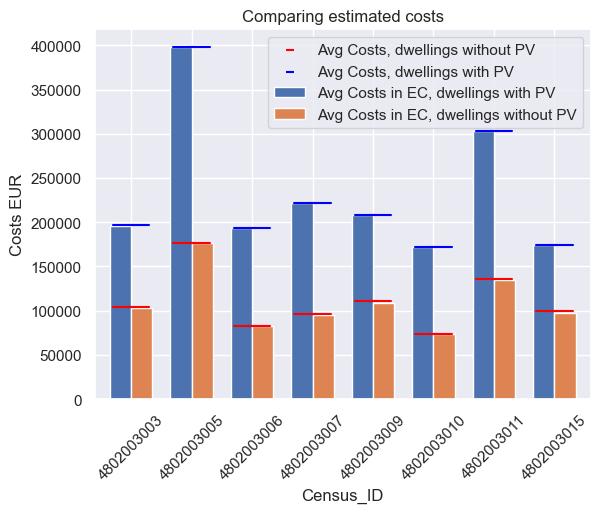

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

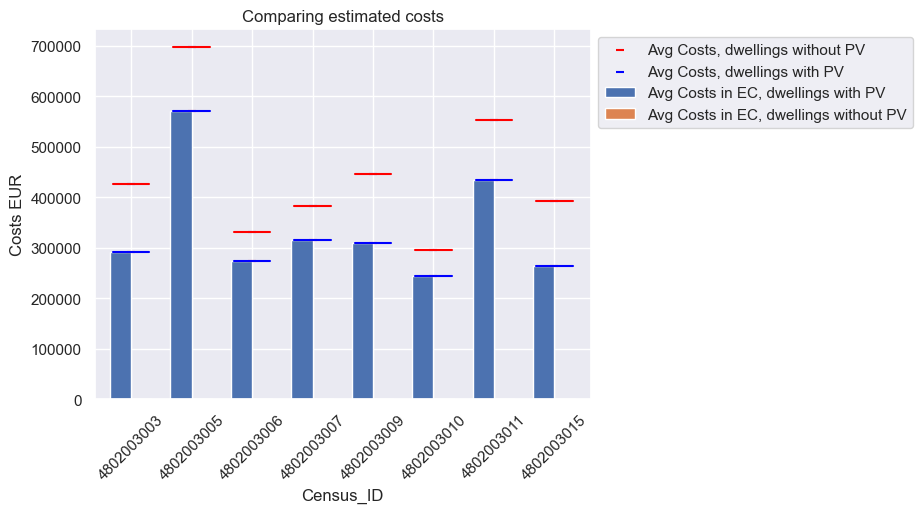

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

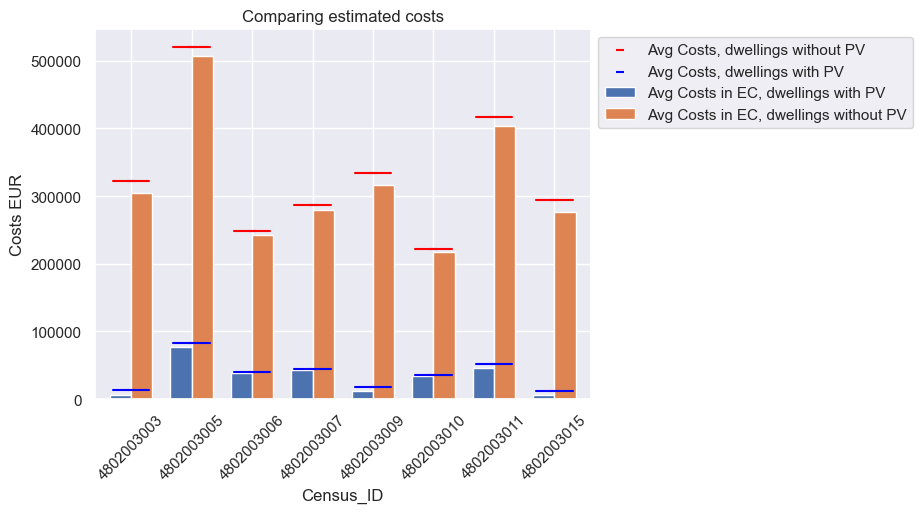

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

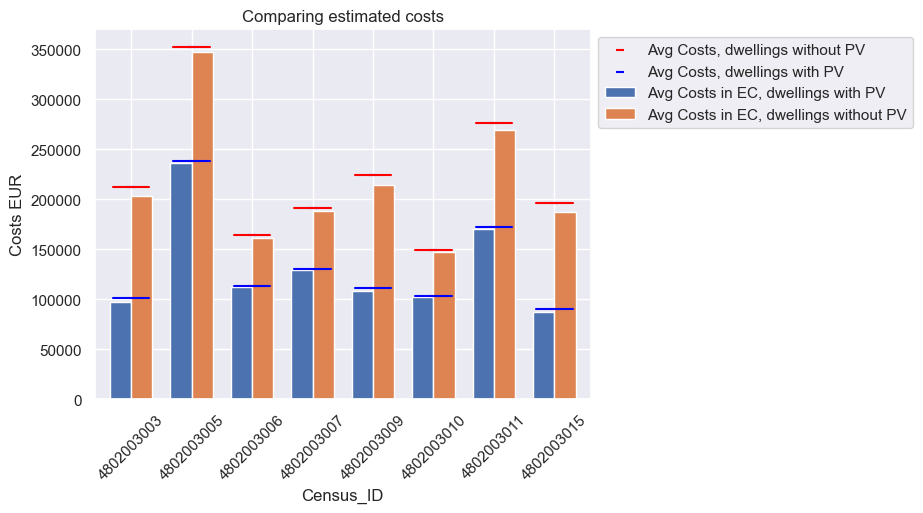

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

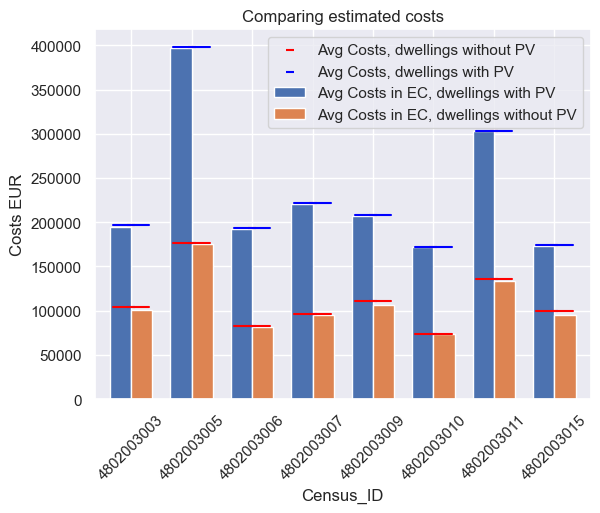

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

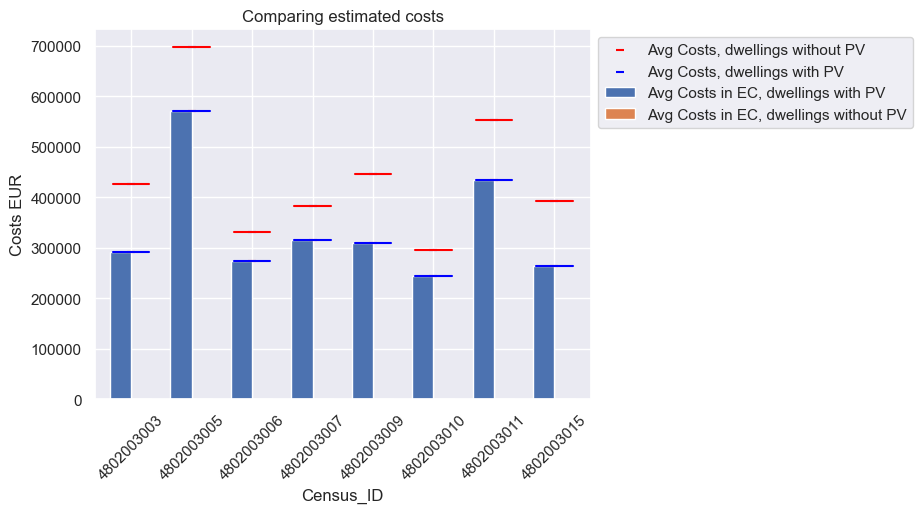

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

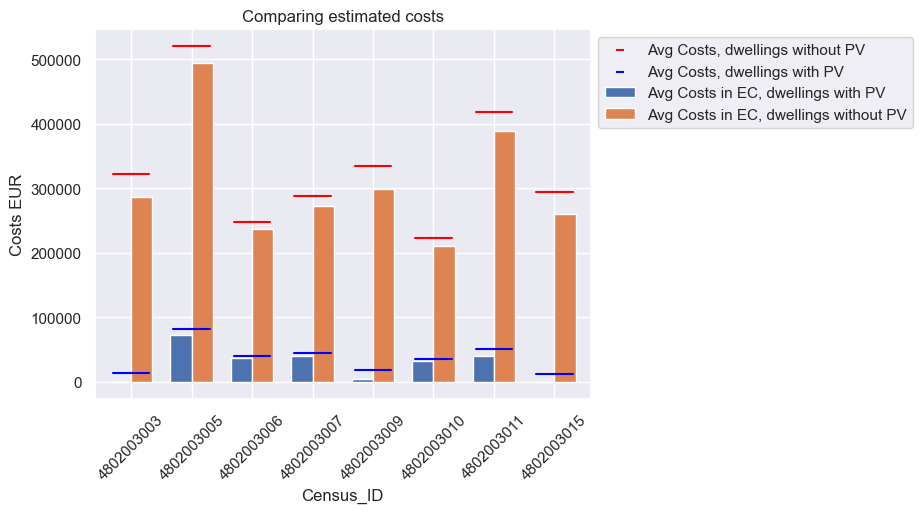

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

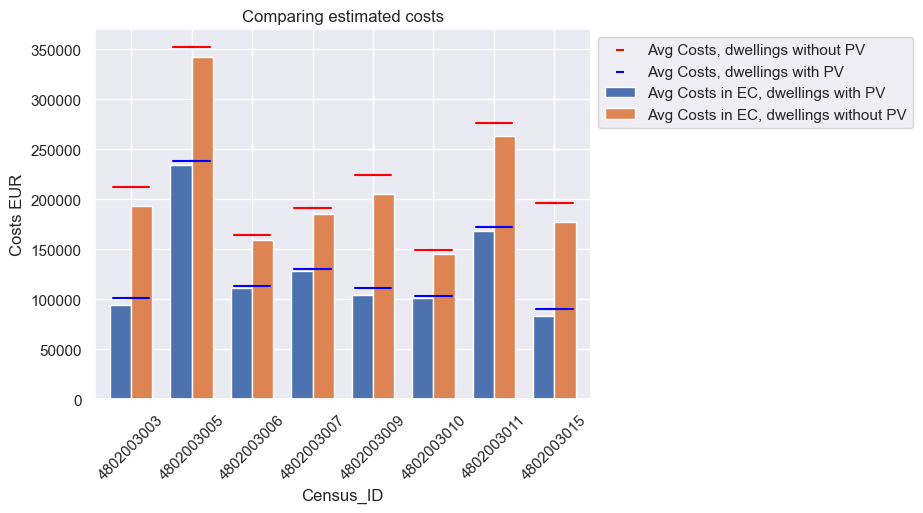

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

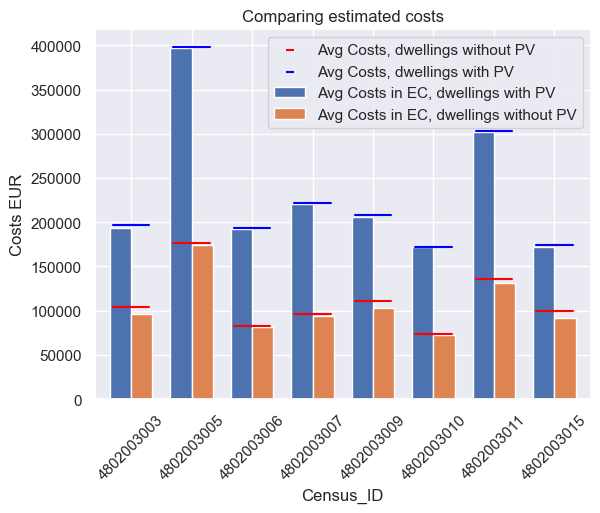

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


Root directory: c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.df_pv_gen = self.df_pv_gen.groupby('census_id').sum().reset_index()


dwelling_by_residents_num


c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'gen_surpl_dir_m{i}'] = self.energy_data[gen_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.energy_data[f'load_resid_dir_m{i}'] = self.energy_data[cons_col] - self.energy_data[f'load_cov_dir_m{i}']
c:\Users\Oleksandr-MSI

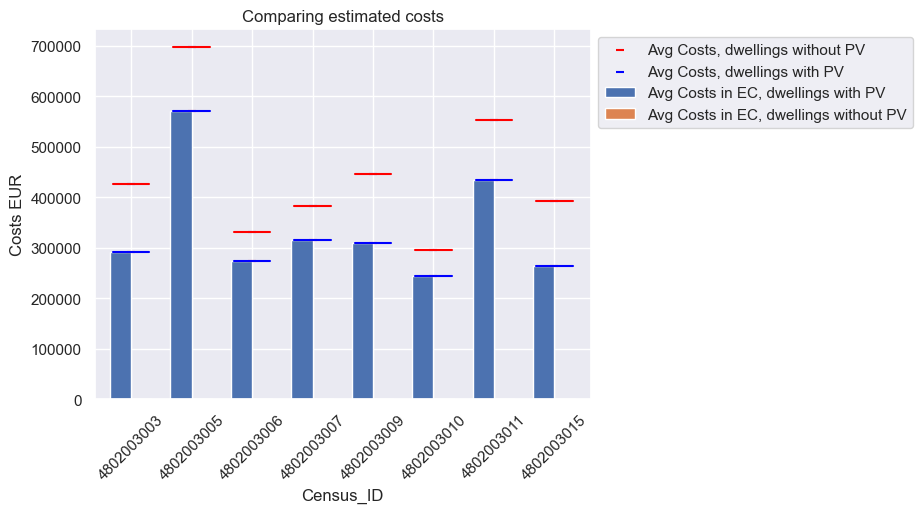

c:\Users\Oleksandr-MSI\Documentos\GitHub\spacer-hb-framework\python\mod_06_enercom_estimator.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_sensitivity_total = self.df_sensitivity_total.append(df_total_cost)
C:\Users\Oleksandr-MSI\AppData\Local\Temp\ipykernel_15364\3644351998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sensitivity_append = df_sensitivity_append.append(df_estimator)


In [18]:
pv_pct_list = [0.25, 0.5, 0.75, 1]
ec_price_coef_list = [0.1, 0.25, 0.5]
df_sensitivity_append = pd.DataFrame()
for ec_price_coef in ec_price_coef_list:
    for pv_pct in pv_pct_list:
        estimator = enercom_estimator.EnercomEstimator(pv_pct=pv_pct, root=PATH, ec_price_coef=ec_price_coef)
        estimator.prepare_energy_data()
        estimator.calculate_costs()
        estimator.export_to_excel()
        df_estimator = estimator.analyze()
        #estimator.plot_saving(df_estimator)
        estimator.monthly_sensitivity_analysis()
        estimator.save_sensitivity()
        df_sensitivity_append = df_sensitivity_append.append(df_estimator)
        
    
estimator.save_sensitivity(df_sensitivity_append)

In [39]:
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import geopandas as gpd
import warnings


def check_and_set_crs(gdf, crs_code="EPSG:25830"):
    if gdf.crs is None:
        print("Warning: GeoDataFrame has no CRS set.")
        print("Assuming ETRS89 / UTM Zone 30N (EPSG:25830) for re-projection as a common case for Spain.")
        print("Please ensure this is correct for your data or set it manually (e.g., df.set_crs('EPSG:25830', inplace=True)).")
        # As a fallback/example, set it here. You should replace with your actual source CRS if different.
        gdf = gdf.set_crs("EPSG:25830", allow_override=True)

    # Reproject the GeoDataFrame to WGS84 (EPSG:4326)
    df_reprojected = gdf.to_crs(epsg=4326)

    return df_reprojected


def geo_interactive_shape_heatmap(df, column_1='NRPE_kWh_per_dwelling', column_2='EUAC_per_dwelling'):

    df_reprojected = check_and_set_crs(df)

    # Ensure the GeoDataFrame has a 'id' column for Plotly to link data to geometries
    if 'id' not in df_reprojected.columns:
        df_reprojected['id'] = df_reprojected.index

    # --- Step 2: Create interactive plots using Plotly Express ---
    # We use px.choropleth_mapbox but set a very minimal background and remove other map elements.

    # Plot for column_1
    fig1 = px.choropleth_mapbox(df_reprojected,
                                geojson=df_reprojected.geometry.__geo_interface__, # Convert geometry to geojson
                                locations=df_reprojected.id, # Link data to geometries using 'id'
                                color=column_1,
                                color_continuous_scale="greens", # Choose a color scale
                                # For a minimal background, use 'white-spatial-lab' or 'carto-darkmatter' if you prefer dark
                                mapbox_style="white-spatial-lab", # This gives a plain white background
                                zoom=12, # Adjust zoom level as needed
                                center={"lat": df_reprojected.geometry.centroid.y.mean(),
                                        "lon": df_reprojected.geometry.centroid.x.mean()},
                                opacity=0.8, # Make the shapes prominent
                                labels={column_1: f'{column_1.replace("_", " ")}'}, # Customize legend title
                                hover_name=df_reprojected.index, # What appears prominently on hover
                                hover_data={column_1: ':.2f', # Format the hovered data
                                            'id': False # Don't show 'id' in hover
                                           }
                               )
    fig1.update_layout(title_text=f"Heatmap of `{column_1.replace('_', ' ')}` by Census Section", title_x=0.5)

    # Crucial for making it *not* look like a traditional map: remove Mapbox layers
    fig1.update_layout(
        mapbox = dict(
            accesstoken=None, # No need for Mapbox token if not using their specific styles/features
            layers=[],        # Remove default Mapbox layers (like roads, labels)
            zoom=fig1.layout.mapbox.zoom, # Keep original zoom/center
            center=fig1.layout.mapbox.center,
            pitch=0,
            bearing=0,
            style="white-bg" # Use a very plain background style
        )
    )

    # Plot for column_2
    fig2 = px.choropleth_mapbox(df_reprojected,
                                geojson=df_reprojected.geometry.__geo_interface__,
                                locations=df_reprojected.id,
                                color=column_2,
                                color_continuous_scale="Plasma",
                                mapbox_style="white-spatial-lab",
                                zoom=12,
                                center={"lat": df_reprojected.geometry.centroid.y.mean(),
                                        "lon": df_reprojected.geometry.centroid.x.mean()},
                                opacity=0.8,
                                labels={column_2: f'{column_2.replace("_", " ")}'},
                                hover_name=df_reprojected.index,
                                hover_data={column_2: ':.2f',
                                            'id': False
                                           }
                               )
    fig2.update_layout(title_text=f"Heatmap of `{column_2.replace('_', ' ')}`", title_x=0.5)
    fig2.update_layout(
        mapbox = dict(
            accesstoken=None,
            layers=[],
            zoom=fig2.layout.mapbox.zoom,
            center=fig2.layout.mapbox.center,
            pitch=0,
            bearing=0,
            style="white-bg"
        )
    )

    fig1.show()
    fig2.show()
    warnings.filterwarnings("ignore")

In [40]:
census_file = os.path.join(os.getcwd(), "vector", "stat_census", "Otxarkoaga.shp")
data_file = os.path.join(os.getcwd(), "data", "06_buildings_with_energy_and_co2_values+HDemProj_facade_costs+PV_economic+EUAC_ORIGIN_ADD_SHEET.xlsx")

df_census = gpd.read_file(census_file)
df_data = pd.read_excel(data_file, sheet_name='Sheet3', dtype={'census_id': str})

df_filter = df_data[df_data["Filter"]=='Comb2S1']
#df_census['census_id'] = df_census['census_id'].astype(str)
df = df_census[['census_id',"geometry"]].merge(df_filter, on='census_id')

# Example Usage (assuming 'df' is your GeoDataFrame with UTM coordinates)
df = df.set_crs("EPSG:25830", inplace=True)
geo_interactive_shape_heatmap(df, column_1='NRPE_Envelope_kWh_per_m2', column_2='Envelope_EUAC_per_m2')

#ignore python warnings


In [10]:
import folium
from folium import GeoJson
import geopandas as gpd
m = folium.Map(location=(43.257928,-2.897791), zoom_start=15)#, tiles='cartodb positron')  # Adjust the location and zoom level as needed

geo=r"data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs_with_HDem_corr.geojson"
gdf = gpd.read_file(geo)
''' 
folium.GeoJson(gdf).add_to(m)
m.add_child(
    folium.LatLngPopup()
)
m
'''
# Replace "census_id" with the actual column you want to show on hover.
# This column must exist in your GeoDataFrame's attributes.
column_for_tooltip = "census_id"

# Get a list of all columns in your GeoDataFrame, EXCLUDING 'geometry',
# to display in the click popup.
columns_for_popup = ["surface_area", "r_area"]# [col for col in gdf.columns if col != 'geometry']

# --- Add the GeoJSON layer to the map with interactivity ---
folium.GeoJson(
    gdf,
    # Style for the polygons
    style_function=lambda feature: {
        "fillColor": "#ffff00",  # Example fill color (yellow)
        "color": "black",       # Border color
        "weight": 2,            # Border weight
        "dashArray": "5, 5",    # Dashed border
        "fillOpacity": 0.7      # Opacity of the fill color
    },
    # Style when hovering over a polygon
    highlight_function=lambda x: {
        "weight": 3,
        "color": "blue",
        "fillOpacity": 0.9
    },
    # Tooltip that appears on hover
    tooltip=folium.GeoJsonTooltip(
        fields=[column_for_tooltip],
        aliases=[column_for_tooltip.replace('_', ' ').title()], # Make tooltip title more readable
        localize=True
    ),
    # Popup that appears on click
    popup=folium.GeoJsonPopup(
        fields=columns_for_popup, # Use the list that excludes 'geometry'
        aliases=[col.replace('_', ' ').title() for col in columns_for_popup], # Make popup titles more readable
        localize=True
    ),
).add_to(m)

# Display the map
m

In [8]:
import leafmap

m = leafmap.Map(center=(43.25, -2.89), zoom=10)

# Add the GeoDataFrame to the map with color scale based on "HDemProj"
m.add_gdf(
    gdf,
    layer_name="Buildings with Energy and CO2 Values",
    column="HDem_iNSPiRE",
    cmap="YlOrRd",
    legend_title="HDem_iNSPiRE",
    style={"fillOpacity": 0.7, "color": "black"}  # <-- fixed comma
)

# Display the map
m


Map(center=[43.25, -2.89], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Index(['build_id', 'census_id', 'Codigo_Pol', 'Codigo_Par', 'building',
       'Numero_Alt', 'year_constr', 'Ano_Rehabi', 'r_area', 'h_mean',
       'h_stdev', 'h_min', 'h_max', 'f_area', 'f_perimeter', 'n_floorsEstim',
       'h_estim', 'len_N', 'len_NW', 'len_E', 'len_SW', 'len_S', 'len_SE',
       'len_W', 'len_NE', 'neighboring_polygons', 'surface_area', 'volume',
       's_v_ratio', 'fa_area_N', 'fa_area_NE', 'fa_area_E', 'fa_area_SE',
       'fa_area_S', 'fa_area_SW', 'fa_area_W', 'fa_area_NW', 'Total_fa_area',
       'Tot_w2wall', 'Tot_window_area', 'f_v_ratio', 'HDem_iNSPiRE',
       'HCons_iNSPiRE', 'CDem_iNSPiRE', 'CCons_iNSPiRE', 'H_CO2_iNSPiRE',
       'index_right', 'HDemProj', 'installed_kWp', 'n_panel', 'Total, kWh',
       'S1_Facd_I_C', 'S1_Facd_M_C', 'S1_Wind_I_C', 'S1_Wind_M_C',
       'S1_Roof_I_C', 'S1_Roof_M_C', 'Comb1S1_HDem_kWh/m2', 'Num dwellings',
       'Avg dwelling size', 'grossFloorArea', 'n_dwellOriginal',
       'n_dwellEstim', 'Comb1S1_HDem_Savings_kWh'

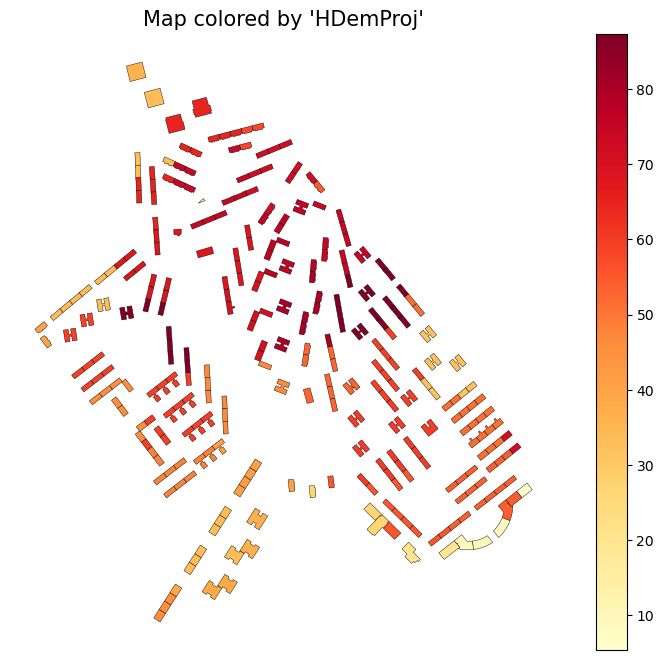

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrame (replace with your file path or data source)
gdf = gpd.read_file('data/05_buildings_with_energy_and_co2_values+HDemProj_facade_costs_with_HDem_corr.geojson')  # could also be .shp or .gpkg

# Check attribute columns
print(gdf.columns)

# Replace 'your_attribute' with the attribute you want to color by
attribute = 'HDemProj'

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column=attribute, 
         ax=ax,
         legend=True, 
         cmap='YlOrRd',  # or 'plasma', 'coolwarm', etc.
         edgecolor='black', 
         linewidth=0.3)

# Title and aesthetics
ax.set_title(f"Map colored by '{attribute}'", fontsize=15)
ax.set_axis_off()

plt.show()


In [ ]:
import geopandas as gpd
import folium
from folium import Choropleth

# Load GeoDataFrame


# Create Folium map 
m = folium.Map(location=(43.257928,-2.897791), zoom_start=15)#, tiles='cartodb positron')  # Adjust the location and zoom level as needed
# Create Folium map centered on geometry centroid
# m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=6)

# Convert GeoDataFrame to GeoJSON for Folium
gdf = gdf.to_crs(epsg=4326)
gjson = gdf.to_json()

# Add choropleth layer
Choropleth(
    geo_data=gjson,
    data=gdf,
    columns=[gdf.index, attribute],
    key_on='feature.id',  # or 'feature.properties.YOUR_ID' if you have an id
    fill_color='YlOrRd',  # Choose a color scale
    fill_opacity=1,
    legend_name=attribute
).add_to(m)

# Optional: Add tooltips
folium.GeoJson(
    gjson,
    tooltip=folium.GeoJsonTooltip(fields=[attribute]),
    style_function=lambda feature: {
        'weight': 0.5,  # <-- border thickness
        'color': 'black',
        'fillOpacity': 0.0  # only line shown if needed
    },
).add_to(m)

# Show or save
m.save("interactive_map.html")
m
